In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt

## 1 - Preparando a base

In [2]:
import numpy as np
import pandas as pd

# seed para a reproducao
np.random.seed(422)

# numero de linhas do dataframe
n = 10000

# Gerando as variáveis confundidoras
X1 = np.random.normal(loc=0, scale=1, size=n)
X2 = np.random.normal(loc=5, scale=2, size=n)
X3 = np.random.choice(['A', 'B'], size=n)

# Codificando X3 para variável numérica
X3_numeric = np.where(X3 == 'B', 1, 0)

# Criando a propensity score
logits = (0.2 * X1) - (0.2 * X2) + (1.0 * X3_numeric)
propensity = 1 / (1 + np.exp(-logits))

# Gerando T
T = np.random.binomial(1, propensity)

# Ruído
noise = np.random.normal(1.5, 4, n)

# ----> Y com relação NÃO LINEAR <----
Y = (2 
     + 3 * np.sqrt(T + 1)               # impacto de T não linear --- ATE = 1.24
     + 1.5 * (X1**2)                    # quadrático em X1
     - 2 * np.log(np.abs(X2) + 1)        # logaritmo de X2
     + 2 * (X3_numeric**2)               # X3_dummy ao quadrado (mas como é 0 ou 1, mantém)
     + noise)

# Construindo o dataframe
df = pd.DataFrame({
    'Y': Y,
    'T': T,
    'X1': X1,
    'X2': X2,
    'X3': X3
})

In [3]:
df.head()

,Y,T,X1,X2,X3
0,8.152606,0,-0.689625,9.263023,A
1,10.371396,0,-1.334058,7.404452,B
2,7.999956,0,0.554514,1.811336,A
3,2.684620,0,-0.774483,5.144973,B
4,5.758653,0,0.065460,4.653085,B


In [4]:
# Transformando a variavel qualitativa via dummie (assumindo B como referencia)
dummies = pd.get_dummies(df['X3'], prefix='X3', drop_first=True, dtype=float)

# Inserindo a nova variavel no data frame original
df = pd.concat([df, dummies], axis=1)

In [5]:
df.head()

,Y,T,X1,X2,X3,X3_B
0,8.152606,0,-0.689625,9.263023,A,0.0
1,10.371396,0,-1.334058,7.404452,B,1.0
2,7.999956,0,0.554514,1.811336,A,0.0
3,2.684620,0,-0.774483,5.144973,B,1.0
4,5.758653,0,0.065460,4.653085,B,1.0


In [6]:
# Nome das variaveis que serao as confundidoras do modelo
features_base = ['X1','X2','X3_B']

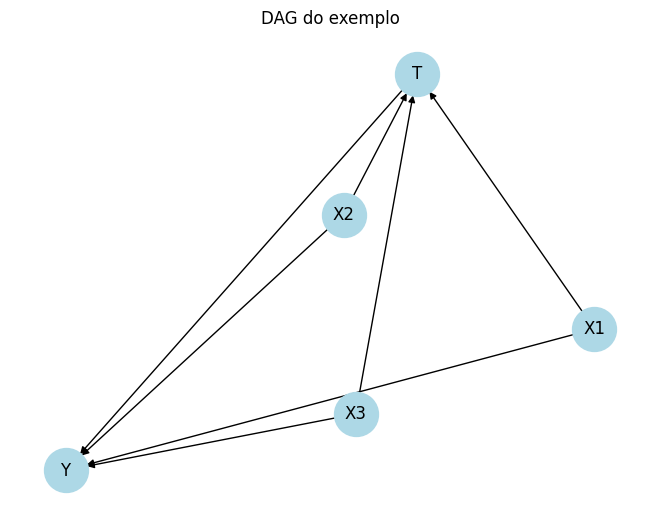

In [7]:
# Visualizacao do DAG
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar arestas (de onde -> para onde)
G.add_edges_from([
    ("T", "Y"),
    ("X1", "Y"),
    ("X2", "Y"),
    ("X3", "Y"),
    ("X1", "T"),
    ("X2", "T"),
    ("X3", "T"),
])

# Desenhar o grafo
pos = nx.spring_layout(G)  # Layout automático
nx.draw(G, pos, with_labels=True, arrows=True, node_size=1000, node_color="lightblue", font_size=12)
plt.title("DAG do exemplo")
plt.show()

## 2 - Verificando o pressuposto da positividade

In [8]:
# Para evitar o overfitting no calculo do propensity score, vamos separar a base em duas, assim, treinaremos dois modelos
np.random.seed(42)
df1 = df.sample(frac = 0.5)
df2 = df.drop(df1.index)

In [9]:
from sklearn.linear_model import LogisticRegression
# Vamos fazer duas regressoes logisticas para estimar os propensity scores, cada uma vai ser treinada em metade da base
logit1 = LogisticRegression()
logit2 = LogisticRegression()

# Treinando os modelos em cada parte da base, prevendo T com base nas variaveis confundidoras (X)
logit1.fit(df1[['X1', 'X2', 'X3_B']], df1['T'])
logit2.fit(df2[['X1', 'X2', 'X3_B']], df2['T'])


# O modelo treinado na base 1 vai ser usado para calcular o score na base 2
# O modelo treinado na base 2 vai ser usado para calcular o score na base 1
df1['propensity_score'] = logit2.predict_proba(df1[['X1', 'X2', 'X3_B']])[:, 1]
df2['propensity_score'] = logit1.predict_proba(df2[['X1', 'X2', 'X3_B']])[:, 1]

# juntando as bases novamente
df_f = pd.concat([df1,df2])

In [10]:
df_f.head()

,Y,T,X1,X2,X3,X3_B,propensity_score
6252,13.525385,1,-1.853598,3.874194,B,1.0,0.490423
4684,8.494246,1,-0.813155,5.249052,B,1.0,0.458626
1731,8.851926,0,-0.525914,4.146047,A,0.0,0.293096
4742,0.546085,0,0.276478,8.660110,A,0.0,0.159445
4521,4.677539,1,-0.227592,3.596237,B,1.0,0.560359


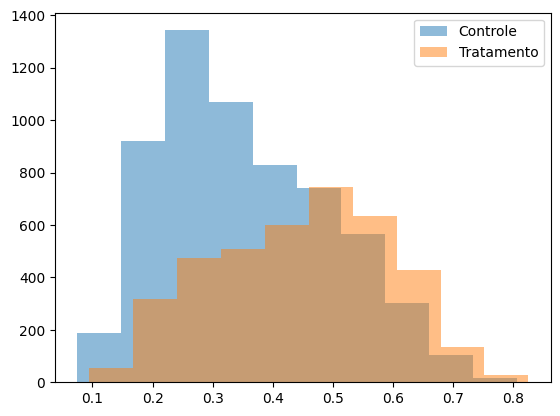

In [11]:
import matplotlib.pyplot as plt
# Visualizando se temos unidades de controle e tratamento nas mesmas faixas do propensity score (Pressuposto da Positividade)
plt.hist(df_f[df_f['T'] == 0]['propensity_score'], label = 'Controle', alpha = 0.5)
plt.hist(df_f[df_f['T'] == 1]['propensity_score'], label = 'Tratamento', alpha = 0.5)
plt.legend()
plt.show()

## 3 - Verificando equilibrio entre as variaveis X dos grupos controle e tratamento (SMD)

In [12]:
# Função para SMD contínuas
def compute_smd_continuous(x, t):
    treated = x[t == 1]
    control = x[t == 0]
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((np.var(treated, ddof=1) + np.var(control, ddof=1)) / 2)
    return mean_diff / pooled_std

# Função para SMD categóricas
def compute_smd_categorical(x, t):
    treated = pd.crosstab(index=t, columns=x, normalize='index').loc[1]
    control = pd.crosstab(index=t, columns=x, normalize='index').loc[0]
    smd = np.sum(np.abs(treated - control)) / 2
    return smd

# Identificando variáveis contínuas e categóricas
continuous_vars = ['X1','X2']
categorical_vars = ['X3']

# Calculando SMDs
smd_results = {}

for col in continuous_vars:
    smd = compute_smd_continuous(df[col], df['T'])
    smd_results[col] = smd

for col in categorical_vars:
    smd = compute_smd_categorical(df[col], df['T'])
    smd_results[col] = smd

# Criar DataFrame de SMDs
smd_df = pd.DataFrame.from_dict(smd_results, orient='index', columns=['SMD'])
smd_df = smd_df.sort_values(by='SMD', ascending=False)

print("📋 Relatório de Balanceamento:")
print(smd_df)

📋 Relatório de Balanceamento:
         SMD
X3  0.238680
X1  0.154279
X2 -0.378367


## 4 - Verificando o resultado de uma regressao linear Y ~ T

In [13]:
import statsmodels.api as sm

In [14]:
X = df[['T']]
y = df[['Y']]
# Adicionar constante
X_const = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X_const)
results = model.fit()

# Exibir o resumo completo
print(results.summary())

#O impacto de T (1.822 - 2.135) não contem o valor especificado na funcao geradora dos dados (ATE = 1.24)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     416.0
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           1.24e-90
Time:                        15:08:19   Log-Likelihood:                -29703.
No. Observations:               10000   AIC:                         5.941e+04
Df Residuals:                    9998   BIC:                         5.943e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2491      0.061     86.728      0.0

## 5 - Ajustando os modelos do DoubleML

In [15]:
import xgboost as xgb
# Ajustando os modelos de XGBoost que serão usados

# Modelo que preve o Outcome (Y) com base nas confundidoras (X)
boost = xgb.XGBRegressor(n_jobs=1, objective = "reg:squarederror")

# Modelo que preve o Tratamento (T) com base nas confundidoras (X)
boost_class = xgb.XGBClassifier(n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

In [16]:
import doubleml as dml
# Inicializando o DoubleML
data_dml_base = dml.DoubleMLData(df,
                                 y_col='Y',
                                 d_cols='T',
                                 x_cols=features_base)

In [17]:
np.random.seed(42)
# Ajustando o DoubleML, definindo o numero de folds para o cross-fiting (n_folds) e número de repeticoes do processo (n_rep)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 10,
                                n_rep = 5)

In [18]:
# Hiperparametros que serao tunados de cada modelo de XGBoost (Y~X e T~X)
par_grids = {'ml_l': {'learning_rate': [0.01, 0.05, 0.1, 0.2,0.5,1],
    'n_estimators': [100, 200, 300,500,900,1200],
    'max_depth': [3, 4, 5, 6,8,10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3,0.5,1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1,0.3,0.5,0.8, 1,10],
    'reg_lambda': [0, 0.1,0.3,0.5,0.8, 1,10]},
             'ml_m': {'learning_rate': [0.01, 0.05, 0.1, 0.2,0.5,1],
    'n_estimators': [100, 200, 300,500,900,1200],
    'max_depth': [3, 4, 5, 6,8,10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3,0.5,1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1,0.3,0.5,0.8, 1,10],
    'reg_lambda': [0, 0.1,0.3,0.5,0.8, 1,10]}}

In [19]:
np.random.seed(42)
#tunando os modelos via random search
dml_plr_boost.tune(par_grids, search_mode='randomized_search', n_iter_randomized_search=500)

## 6 - Executando o DoubleML

In [20]:
# Rodando o modelo DoubleML utilizando os melhores hiperparametros encontrados
dml_plr_boost.fit(store_predictions=True)

# Mostrando o impacto de T em Y e seus respectivos intervalos de confianca (com Bootstrap ao final)
print(dml_plr_boost.summary)
print(dml_plr_boost)
bootstrap_results = dml_plr_boost.bootstrap(method='normal', n_rep_boot=500) # intervalo de confianca com Bootstrap
print("Bootstrap confidence intervals:\n", bootstrap_results.confint(joint=True))

       coef   std err          t         P>|t|     2.5 %    97.5 %
T  1.232622  0.087466  14.092551  4.220350e-45  1.060979  1.403927
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['T']
Covariates: ['X1', 'X2', 'X3_B']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_ca